### Подготовления

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from tqdm.auto import tqdm

from typing import Callable

Определяем функцию для отрисовки трёхмерного графика

In [2]:
def plot_function(x, y, func, func_optimums, title, azim=60, found_optimums=np.empty([0, 2])):
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(projection='3d'))
    ax.plot_surface(X, Y, Z, cmap='RdBu', edgecolor='k', alpha=0.6)
    for index, optimum in enumerate(found_optimums):
        z = func(*optimum)
        ax.scatter(
            optimum[0], optimum[1], z, color='orange', s=200,
            label=f'Найденная точка оптимума {index + 1}: {round(optimum[0], 3), round(optimum[1], 3)}, f={round(z, 3)}'
        )
    for index, optimum in enumerate(func_optimums):
        z = func(*optimum)
        ax.scatter(
            optimum[0], optimum[1], z, color='green', s=100,
            label=f'Исходная точка оптимума {index + 1}: {round(optimum[0], 3), round(optimum[1], 3)}, f={round(z, 3)}'
        )
    ax.legend()
    ax.azim = azim
    fig.suptitle(title)
    plt.show()

In [3]:
x, y = [np.arange(-5, 5.01, 0.01) for _ in range(2)]

Определяем функцию Матьяса и функцию, вычисляющую её частные производные

In [4]:
def mattias(x, y):
    return 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y


def mattias_grad(x, y):
    grad_x = 0.52 * x - 0.48 * y
    grad_y = 0.52 * y - 0.48 * x
    return np.array([grad_x, grad_y])


opts_mattias = np.array([[0, 0]])

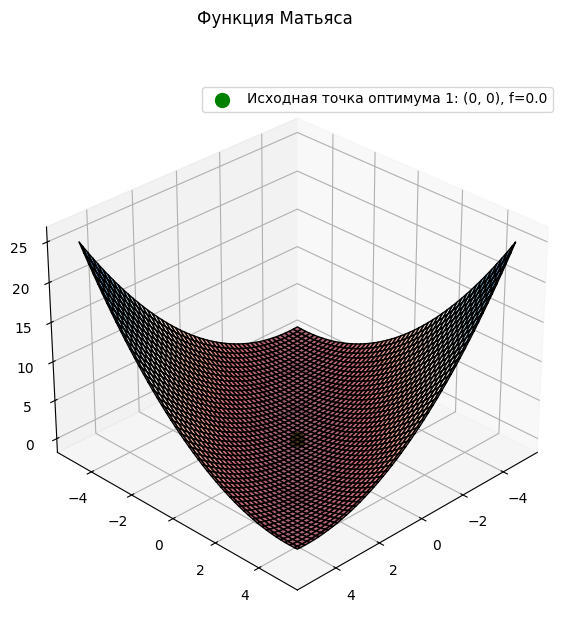

In [5]:
plot_function(x, y, mattias, opts_mattias, 'Функция Матьяса', azim=45)

Определяем функцию Голдстейна-Прайса и функцию, вычисляющую её частные производные

In [6]:
def goldstein_price_1(x, y):
    return (1 + np.square(x + y + 1) * (19 - 14 * x + 3 * np.square(x) - 14 * y + 6 * x * y + 3 * np.square(y)))


def goldstein_price_2(x, y):
    return (30 + np.square(x * 2 - y * 3) * (18 - 32 * x + 12 * np.square(x) + 48 * y - 36 * x * y + 27 * np.square(y)))


def goldstein_price_grad_1(x, y):
    grad_x = (x + y + 1) * (12 * np.square(x) + 12 * np.square(y) + 24 * x * y - 36 * x - 36 * y + 24)
    grad_y = (x + y + 1) * (12 * np.square(x) + 12 * np.square(y) + 24 * x * y - 36 * x - 36 * y + 24)
    return grad_x, grad_y


def goldstein_price_grad_2(x, y):
    grad_x = (2 * x - 3 * y) * (96 * np.square(x) + 216 * np.square(y) - 288 * x * y - 192 * x + 288 * y + 72)
    grad_y = (3 * y - 2 * x) * (144 * np.square(x) + 324 * np.square(y) - 432 * x * y - 288 * x + 432 * y + 108)
    return grad_x, grad_y


def goldstein_price(x, y):
    return goldstein_price_1(x, y) * goldstein_price_2(x, y)


def goldstein_price_grad(x, y):
    grad_x_1, grad_y_1 = goldstein_price_grad_1(x, y)
    grad_x_2, grad_y_2 = goldstein_price_grad_2(x, y)
    func_1 = goldstein_price_1(x, y)
    func_2 = goldstein_price_2(x, y)
    grad_x = grad_x_1 * func_2 + func_1 * grad_x_2
    grad_y = grad_y_1 * func_2 + func_1 * grad_y_2
    return np.array([grad_x, grad_y])


opts_goldstein_price = np.array([[0, -1]])

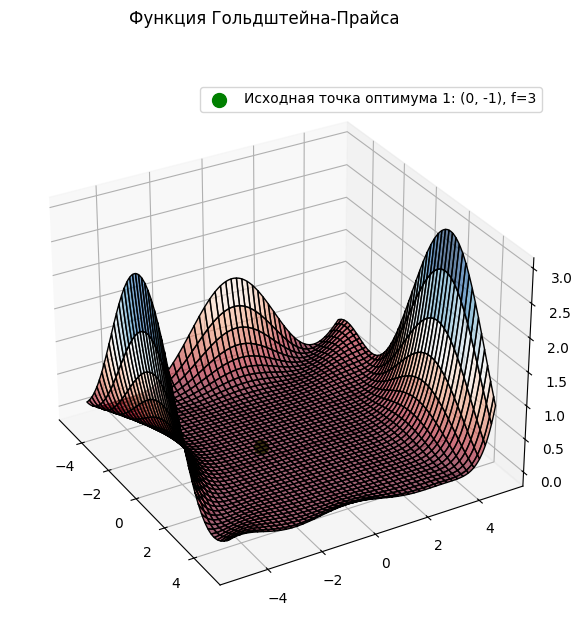

In [7]:
plot_function(x, y, goldstein_price, opts_goldstein_price, 'Функция Гольдштейна-Прайса', azim=-30)

Далее приведены функции для тренировки модели, вычисления learning rate в зависимости от номера текущей итерации и вывода лога со значением метрики RMSE

In [24]:
def get_learning_rate(learning_rate, iteration):
    if isinstance(learning_rate, Callable):
        return learning_rate(iteration)
    return learning_rate

In [25]:
def print_message(epoch, func, coords, opt):
    print(f'{epoch} | RMSE = {np.sqrt(np.mean(np.square(func(*coords) - opt)))}')

In [104]:
def train(algorithm, func, grad, learning_rate, epochs, repeat=1, low=1e-18, high=1e18, verbose=False, opt=None, optimizer_params=None):
    results = np.empty([0, 2])
    pbar = tqdm(range(repeat))
    for cycle in pbar:
        pbar.set_description(f'{cycle} cycle of training...')
        coords = np.random.uniform(low=low, high=high, size=2)
        if optimizer_params is not None:
            optimizer = algorithm(**optimizer_params)
        else:
            optimizer = algorithm()
        for iteration in tqdm(range(epochs), desc='Training'):
            if verbose and opt is not None and iteration % verbose == 0:
                print_message(iteration, func, coords, opt)
            current_learning_rate = get_learning_rate(learning_rate, iteration + 1)
            coords = optimizer(grad, coords, learning_rate, iteration + 1)
        if verbose and opt is not None and epochs % verbose == 0:
            print_message(epochs, func, coords, opt)
        results = np.vstack((results, coords))
    if results.shape[0] == 1:
        results = results[0]
    return results

### Классический градиентный спуск

In [27]:
class GradientDescent():
    def __call__(self, grad, coords, learning_rate, iteration):
        current_learning_rate = get_learning_rate(learning_rate, iteration)
        coords -= current_learning_rate * grad(*coords)
        return coords

In [28]:
mattias_gd = train(
    GradientDescent, mattias, mattias_grad,
    learning_rate=0.1, epochs=10000, repeat=5,
    low=-10, high=10, opt=opts_mattias[0]
)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

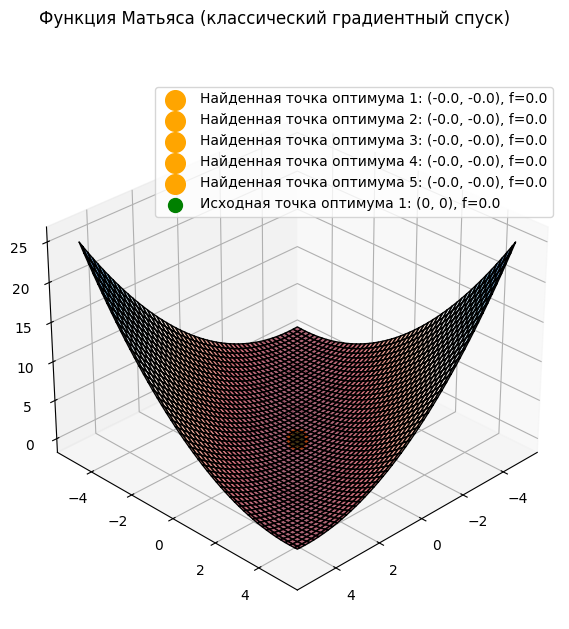

In [29]:
plot_function(
    x, y, mattias, opts_mattias, 'Функция Матьяса (классический градиентный спуск)', azim=45,
    found_optimums=mattias_gd
)

Для функции Матьяса уже обычный градиентный спуск нашёл оптимумы правильно для всех 5 итераций

In [56]:
goldstein_price_gd = train(
    GradientDescent, goldstein_price, goldstein_price_grad,
    learning_rate=5e-6, epochs=50000, repeat=5,
    low=-2, high=2, opt=opts_goldstein_price[0]
)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

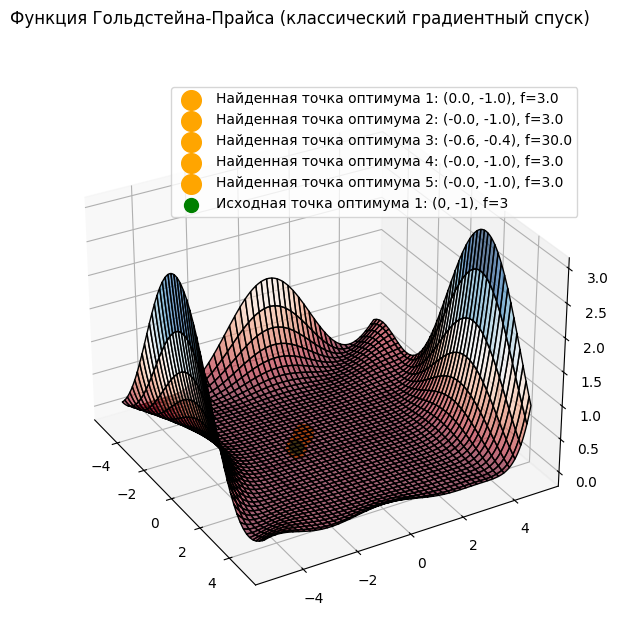

In [57]:
plot_function(
    x, y, goldstein_price, opts_goldstein_price, 'Функция Гольдстейна-Прайса (классический градиентный спуск)', azim=-30,
    found_optimums=goldstein_price_gd
)

Для функции Гольдстейна-Прайса оптимумы правильно нашлись 4 раза, но так бывает далеко не вмегда, обычно из 5 запусков успешными оказываются только 2, реже 1 или 3

### Адаптивный метод Нестерова

In [58]:
class NesterovMomentum():
    def __init__(self, beta=0.9):
        self.beta = beta
        self.velocity = None

    def __call__(self, grad, coords, learning_rate, iteration):
        current_learning_rate = get_learning_rate(learning_rate, iteration)
        if self.velocity is None:
            self.velocity = np.zeros_like(coords)
        self.velocity = self.beta * self.velocity - current_learning_rate * \
            grad(*coords + self.beta * self.velocity)
        coords += self.velocity
        return coords

In [59]:
mattias_nesterov = train(
    NesterovMomentum, mattias, mattias_grad,
    learning_rate=0.1, epochs=10000, repeat=5,
    low=-10, high=10, opt=opts_mattias[0]
)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

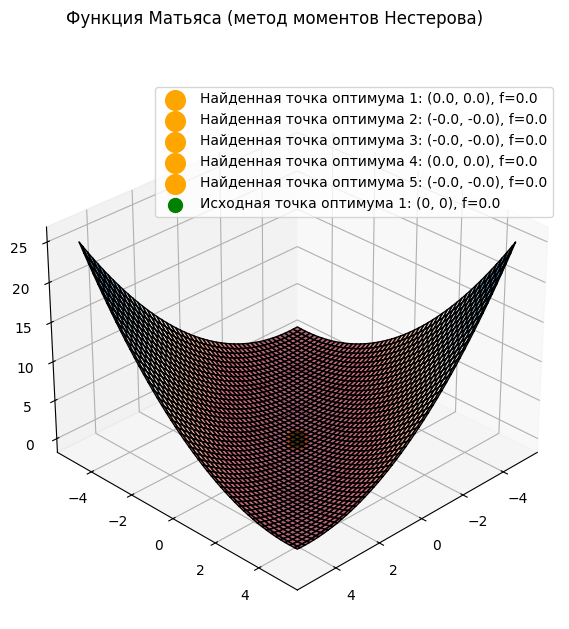

In [60]:
plot_function(
    x, y, mattias, opts_mattias, 'Функция Матьяса (метод моментов Нестерова)', azim=45,
    found_optimums=mattias_nesterov
)

На графике этого не видно, но теперь найденные оптимумы для функции Матьяса стали значительно ближе к исходному оптимуму, чем раньше

In [75]:
goldstein_price_nesterov = train(
    NesterovMomentum, goldstein_price, goldstein_price_grad,
    learning_rate=1e-6, epochs=50000, repeat=5,
    low=-2, high=2, opt=opts_goldstein_price[0]
)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

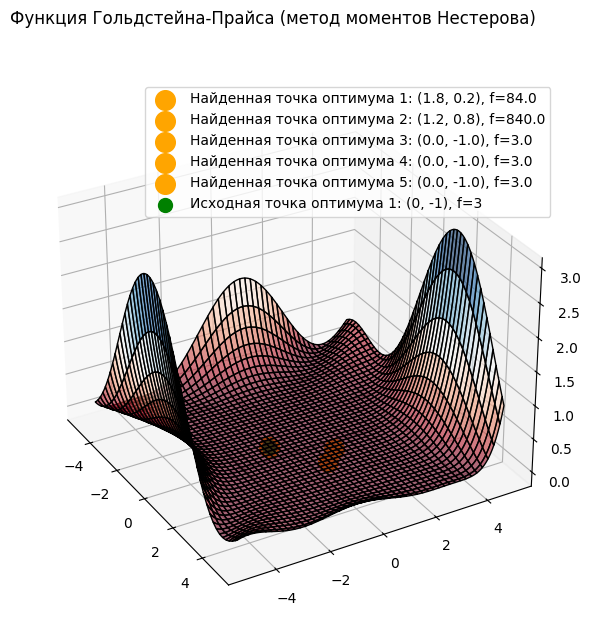

In [77]:
plot_function(
    x, y, goldstein_price, opts_goldstein_price, 'Функция Гольдстейна-Прайса (метод моментов Нестерова)', azim=-30,
    found_optimums=goldstein_price_nesterov
)

На сей раз нашлось только 3 правильных оптимума (они, как и в предыдущем случае, ближе к исходной точке оптимума)

Так тоже бывает далеко не всегда, но моментная модификация Нестерова стабильнее находит правильные точки оптмума в отличие от градиентого спуска (здесь почти всегда есть 3 минимума)

### RMSProp

In [78]:
class RMSProp():
    def __init__(self, gamma=0.99, epsilon=1e-8):
        self.gamma = gamma
        self.epsilon = epsilon
        self.G = None

    def __call__(self, grad, coords, learning_rate, iteration):
        if self.G is None:
            self.G = np.zeros_like(coords)
        local_grad = grad(*coords)
        self.G = self.gamma * self.G + (1 - self.gamma) * np.square(local_grad)
        current_learning_rate = get_learning_rate(learning_rate, iteration)
        coords -= current_learning_rate * local_grad / np.sqrt(self.G + self.epsilon)
        return coords

In [79]:
mattias_rmsprop = train(
    RMSProp, mattias, mattias_grad,
    learning_rate=0.0001, epochs=100000, repeat=5,
    low=-10, high=10, opt=opts_mattias[0],
)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Здесь пришлось уменьшить learning rate и увеличить количество итераций для того, чтобы всё сошлось

Если learning rate слишком большой, то алгоритм застревает в точке, близкой к нулю и не может двигаться в сторону нуля

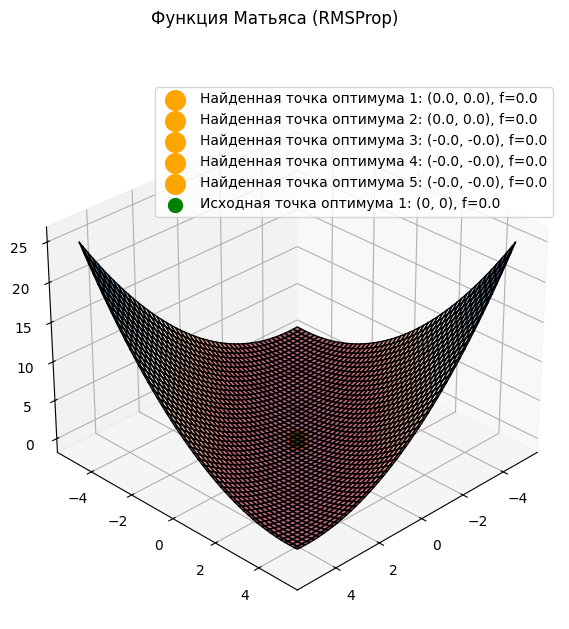

In [81]:
plot_function(
    x, y, mattias, opts_mattias, 'Функция Матьяса (RMSProp)', azim=45,
    found_optimums=mattias_rmsprop
)

In [82]:
goldstein_price_rmsprop = train(
    RMSProp, goldstein_price, goldstein_price_grad,
    learning_rate=5e-3, epochs=50000, repeat=5,
    low=-2, high=2, opt=opts_goldstein_price[0]
)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

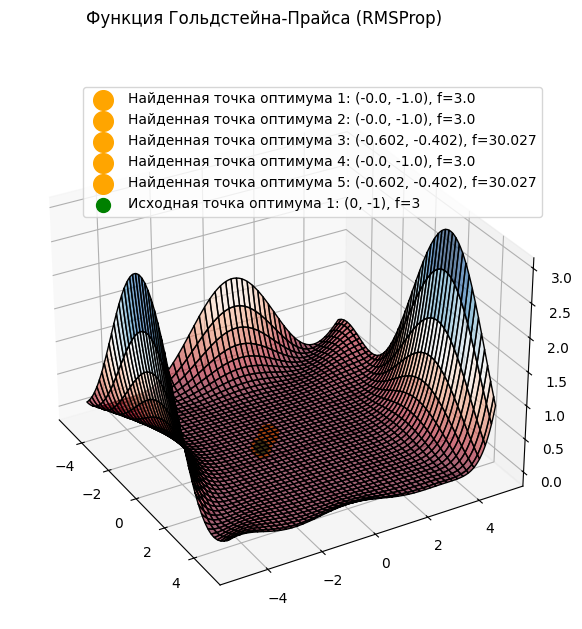

In [84]:
plot_function(
    x, y, goldstein_price, opts_goldstein_price, 'Функция Гольдстейна-Прайса (RMSProp)', azim=-30,
    found_optimums=goldstein_price_rmsprop
)

Из плюсов оптимизатора RMSProp для функции Гольдстейна-Прайса можно отметить то, что теперь можно ставить learning rate больше, чем 1e-6 и не бояться переполнения, так как благодаря скользящему среднему квадратов градиентов взрыва градиента происходить не будет

### AdamW

Попробуем совместить моментную и адаптивную модификацию в лице оптимизатора AdamW

Реализация была сделана по формулам из документации PyTorch

In [125]:
class AdamW():
    def __init__(self, gamma=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0.01):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.velocity = None
        self.G = None

    def __call__(self, grad, coords, learning_rate, iteration):
        if self.velocity is None:
            self.velocity = np.zeros_like(coords)
        if self.G is None:
            self.G = np.zeros_like(coords)
        local_grad = grad(*coords)
        self.velocity = self.beta1 * self.velocity + (1 - self.beta1) * local_grad
        self.G = self.beta2 * self.G + (1 - self.beta2) * np.square(local_grad)
        local_velocity = self.velocity / (1 - self.beta1 ** iteration)
        local_G = self.G / (1 - self.beta2 ** iteration)
        current_learning_rate = get_learning_rate(learning_rate, iteration)
        coords -= current_learning_rate * (
            self.weight_decay * coords + local_velocity / np.sqrt(local_G + self.epsilon)
        )
        return coords

In [106]:
mattias_adamw = train(
    AdamW, mattias, mattias_grad,
    learning_rate=0.0001, epochs=100000, repeat=5,
    low=-10, high=10, opt=opts_mattias[0]
)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

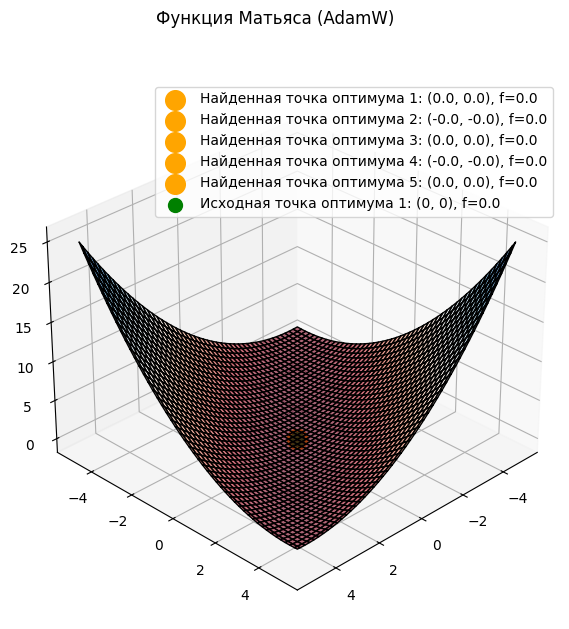

In [108]:
plot_function(
    x, y, mattias, opts_mattias, 'Функция Матьяса (AdamW)', azim=45,
    found_optimums=mattias_adamw
)

Для функции Матьяса оптимизатор AdamW находит самые близкие точки оптимума к исходной

In [134]:
goldstein_price_adamw = train(
    AdamW, goldstein_price, goldstein_price_grad,
    learning_rate=1e-3, epochs=100000, repeat=5,
    low=-2, high=2, opt=opts_goldstein_price[0]
)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

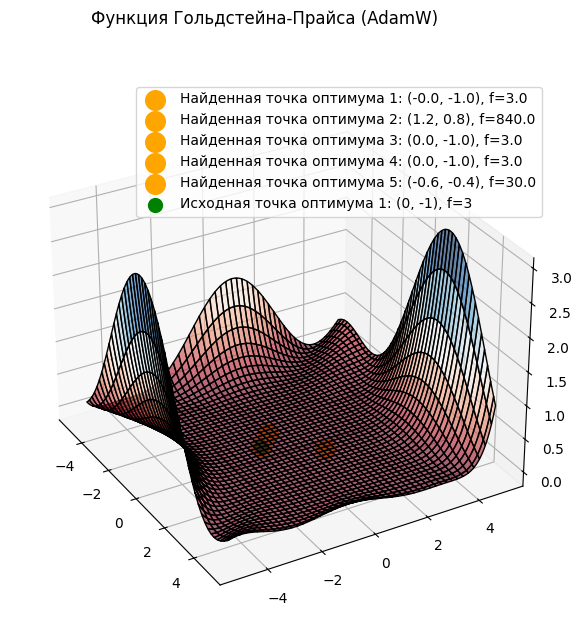

In [136]:
plot_function(
    x, y, goldstein_price, opts_goldstein_price, 'Функция Гольдстейна-Прайса (AdamW)', azim=-30,
    found_optimums=goldstein_price_adamw
)

Алгоритм по-прежнему застревает в минимумах, однако для обучения можно использовать достаточно большой learning rate, не боясь численного переполнения

Стоит ометить, что минимумы, которые находит AdamW для функции Гольдстейна-Прайса находятся дальше от точки оптимума, чем те минимумы, которые для этой же функции находят Nesterov Momentum и RMSProp

### Изменяемый шаг обучения

Давайте сделаем это на примере оптимизатора RMSProp

learning rate будет изменяться по следующему закону: $lr_i=\frac{0.999^i}{2}$

In [145]:
decay = lambda iteration: 0.5 * 0.999 ** iteration

In [146]:
mattias_rmsprop_decay = train(
    RMSProp, mattias, mattias_grad,
    learning_rate=decay, epochs=10000, repeat=5,
    low=-10, high=10, opt=opts_mattias[0]
)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

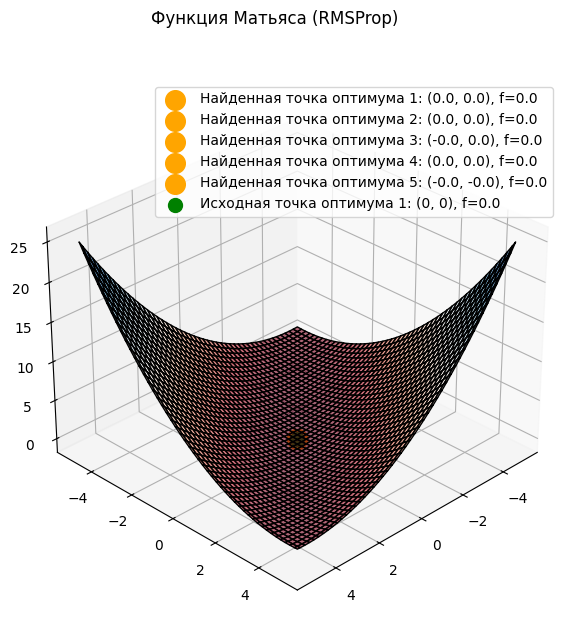

In [148]:
plot_function(
    x, y, mattias, opts_mattias, 'Функция Матьяса (RMSProp)', azim=45,
    found_optimums=mattias_rmsprop_decay
)

In [151]:
goldstein_price_rmsprop_decay = train(
    RMSProp, goldstein_price, goldstein_price_grad,
    learning_rate=decay, epochs=50000, repeat=5,
    low=-2, high=2, opt=opts_goldstein_price[0]
)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

In [152]:
goldstein_price_rmsprop_decay

array([[-1.08598541e-16, -1.00000000e+00],
       [ 1.96880807e-17, -1.00000000e+00],
       [ 1.80000000e+00,  2.00000000e-01],
       [-1.10163908e-16, -1.00000000e+00],
       [ 1.80000000e+00,  2.00000000e-01]])

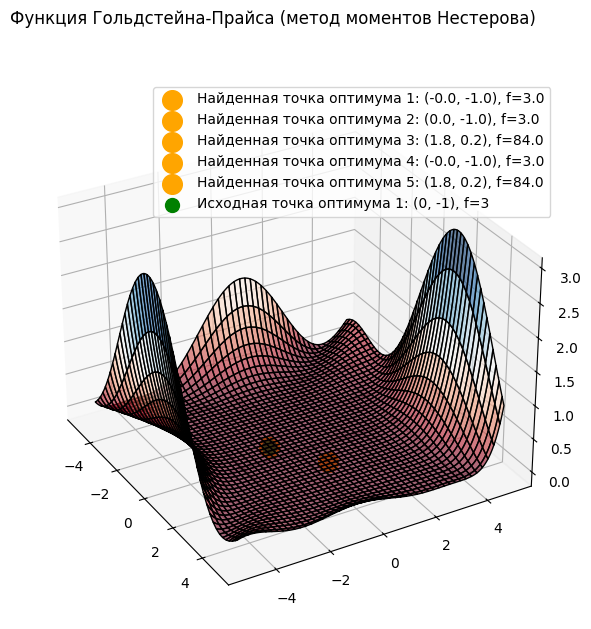

In [153]:
plot_function(
    x, y, goldstein_price, opts_goldstein_price, 'Функция Гольдстейна-Прайса (метод моментов Нестерова)', azim=-30,
    found_optimums=goldstein_price_rmsprop_decay
)

Ну, хотя бы нет локальных оптимумов, где значение функции равняется 840, как в предыдущих случаях. И на том спасибо

### Выводы

В данной лабораторной работе я реализовал 4 оптимизатора - классический градиентный спуск, метод моментов Нестерова, RMSProp и AdamW. Они были протестированы на 2 функциях - Матьяса и Гольдстейна-Прайса

1) Для функции Матьяса достаточно было воспользоваться классическим градиентным спуском, он итак очень хорошо находил все оптимумы

2) Для функции Гольдстейна-Прайса всё несколько сложнее - ни один из оптимизаторов за 5 попыток не нашёл 5 раз правильную точку оптимума
   * Классический радиентный спуск был очень нестабилен. Мог правильно произвести 4 запуска из 5, а мог только одну
   * Метод моментов Нестерова был в этом плане более стабилен и находил более близкие к оптимуму точки, чем классический градиентный спуск
   * RMSProp позволил использовать бОльшие learning rate-ы, и при этом среди всех оптимизаторов находил самые близкие  очки к исходной точке оптимума
   * AdamW был хуже и RMSProp, и метода моментов Нестерова. На него были надежды, но увы...

3) Метод изменения learning rate был протекстирован на оптимизаторе RMSProp? но большого улучшения не дал